In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy

from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, text

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
list(cname for cname in Measurement.__table__.columns)

[Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<measurement>),
 Column('date', TEXT(), table=<measurement>),
 Column('prcp', FLOAT(), table=<measurement>),
 Column('tobs', FLOAT(), table=<measurement>)]

In [11]:
list(cname for cname in Station.__table__.columns)


[Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False),
 Column('station', TEXT(), table=<station>),
 Column('name', TEXT(), table=<station>),
 Column('latitude', FLOAT(), table=<station>),
 Column('longitude', FLOAT(), table=<station>),
 Column('elevation', FLOAT(), table=<station>)]

# Exploratory Climate Analysis

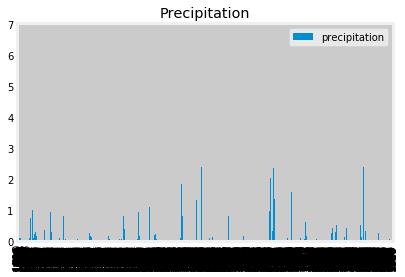

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
tMaxDate = session.query(func.max(Measurement.date) ).first()
maxDate =  datetime.strptime(tMaxDate[0], '%Y-%m-%d').date() 
dt1yrago =  (maxDate - pd.DateOffset(months=12)).date()

# Perform a query to retrieve the data and precipitation scores
#selCols = [Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs]
selCols = [Measurement.date, Measurement.prcp]
resultData =  session.query(*selCols).filter(Measurement.date >= dt1yrago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_prcp = pd.DataFrame(resultData)
df_prcp.set_index('date')

# Sort the dataframe by date
df_prcp = df_prcp.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data

ax = df_prcp.plot.bar(title="Precipitation")
ax.legend(['precipitation'])
ax.x_label = "date"

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df_prcp.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
selCols2 = [Measurement.station,func.count(Measurement.station)]
resultData2 =  session.query(*selCols2).group_by(Measurement.station)
resultData2.count()

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df_stn = pd.DataFrame(resultData2,columns=['station','count'])

# Sort the dataframe by date
df_ostn = df_stn.sort_values(by='count', ascending=False)
df_ostn

,station,count
6,USC00519281,2772
7,USC00519397,2724
1,USC00513117,2709
8,USC00519523,2669
3,USC00516128,2612
2,USC00514830,2202
0,USC00511918,1979
4,USC00517948,1372
5,USC00518838,511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

selCols3 = [Measurement.station,func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
resultData3 =  session.query(*selCols3).filter(Measurement.station ==  df_ostn['station'].iloc[0])
df_stn_active =  pd.DataFrame(resultData3,columns=['station','lowtemp','maxtemp','avgtemp'])

df_stn_active

,station,lowtemp,maxtemp,avgtemp
0,USC00519281,54.0,85.0,71.663781


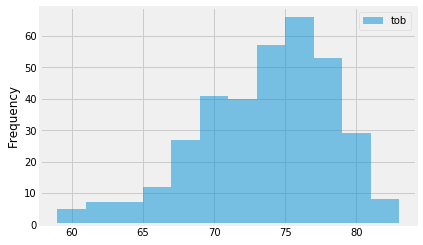

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
resultData4 =  session.query(Measurement.tobs).filter(Measurement.date >= dt1yrago).filter(Measurement.station == df_ostn['station'].iloc[0])
df_tobs = pd.DataFrame(resultData4, columns=['tob'])

df_tobs.plot.hist(bins=12, alpha=0.5)

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = '2017-03-21'
enddate = '2017-03-25'
temp_summ = calc_temps(startdate,enddate)
temp_summ

[(70.0, 73.58620689655173, 78.0)]

Text(0, 0.5, 'Temp(F)')

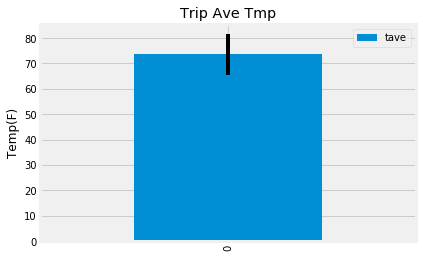

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
df_temp_summ = pd.DataFrame(temp_summ, columns=['tmin','tave','tmax'])

ax = df_temp_summ.plot.bar( y='tave', yerr = df_temp_summ.tmin - df_temp_summ.tmax, title = "Trip Ave Tmp")
ax.set_ylabel("Temp(F)")


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

resultData5 = session.query(func.min(Station.name), func.min(Station.latitude), \
                            func.min(Station.longitude), func.min(Station.elevation), func.sum(Measurement.prcp)). \
        filter(Measurement.station == Station.station). \
        filter(Measurement.date >= startdate).filter(Measurement.date <= enddate).\
        group_by(Station.station)

df_c = pd.DataFrame(resultData5, columns=['station','latitude','longitude','elevation','total_prcp'] )

df_c.sort_values(by='total_prcp', ascending=False)

,station,latitude,longitude,elevation,total_prcp
3,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,1.14
0,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.73
2,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.68
5,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.52
1,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.15
4,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.02


## Optional Challenge Assignment

In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [24]:
# Plot the daily normals as an area plot with `stacked=False`
